In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xml.etree.ElementTree as et

import spacy
nlp = spacy.load('es_core_news_sm')
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

warnings.filterwarnings('ignore')

2022-02-25 13:01:23.207243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 13:01:23.207297: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def xml_to_pandas(xroot):
    
    tweets = []
    for i in range(len(xroot)):
        tweet = []
        for j in range(len(xroot[i])):
            if j==5:
                sentiment = []
                for k in range(len(xroot[i][j])):
                    type = []
                    for l in range(len(xroot[i][j][k])):
                        type.append(xroot[i][j][k][l].text)
                    sentiment.append(type)
                tweet.append(sentiment)
            elif j==6:
                topic = []
                for k in range(len(xroot[i][j])):
                    topic.append(xroot[i][j][k].text)
                tweet.append(topic)
            else:
                tweet.append(xroot[i][j].text)
        tweets.append(tweet)
    output = pd.DataFrame(tweets)
    output.columns = ['tweetid', 'user', 'text', 'time_stamp', 'language', 'sentiment', 'topic']
    return(output)

def get_frame_xml(files, target, features):
    
    df_a = pd.DataFrame()
    for file in files:
        xtree = et.parse(path + file)
        xroot = xtree.getroot()
        df_a = pd.concat([df_a, xml_to_pandas(xroot)], axis=0)
    df_a.reset_index(drop=True, inplace=True)
    df_a['sent'] = df_a['sentiment'].apply(lambda x: x[0][0])
    df_a[target] = np.where(((df_a['sent'] == 'P') | (df_a['sent'] == 'P+')), 1,
                np.where(((df_a['sent'] == 'N') | (df_a['sent'] == 'N+')), 0, np.nan))
    df_a = df_a[~df_a[target].isna()]
    return(df_a[[target, features]])

def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return(s)

def get_stops(stops, path):
    
    with open(path + stops[0]) as f:
        stopw_1 = f.read().splitlines()
    with open(path + stops[1]) as f:
        stopw_2 = f.read().splitlines()

    stopw_1[0] = stopw_1[0].replace('\ufeff', '')
    stopw = stopw_1 + stopw_2
    stopw = [normalize(word) for word in stopw]
    return(stopw)

def remove_stops(data, column, stops):
    for i in range(data.shape[0]):
        token_sent = data[column].iloc[i].split()
        filtered_sent = []
        for w in token_sent:
            if w not in stops:
                filtered_sent.append(w)
        data[column].iloc[i] = ' '.join(filtered_sent)
        doc = nlp(data[column].iloc[i])
        lemmas = [tok.lemma_.lower() for tok in doc]
        data[column].iloc[i] = ' '.join(lemmas)
    return(data)

def text_treatment(data, column, stops):
    
    #Text normalization:
    data[column] = data[column].apply(lambda r: ' '.join(n for n in re.findall('(?<!\S)[a-zA-Z]+(?!\S)', str(r))))
    data[column] = data[column].apply(lambda r: r.lstrip())
    data[column] = data[column].apply(lambda r: r.lower())
    data[column] = data[column].apply(lambda r: normalize(r))
    #Stopwords removal and lemmatization:

    data = remove_stops(data, column, stops)
    return(data)

def create_mod_table(data, target, features, imp):
    
    #Term frequency-Inverse term frequency
    y = data[target]
    X = data[features]
    tf=TfidfVectorizer()
    text_tf= tf.fit_transform(X)

    #Logistic regression for feature importance
    model = LogisticRegression()
    model.fit(text_tf, y)
    importance = model.coef_[0]

    #Feature selection
    keys = list(range(text_tf.shape[1]))
    values = importance
    imp_df = pd.DataFrame(values, keys).rename(columns={0:'values'})
    sel_cols = imp_df[imp_df['values'] > imp].index

    return(text_tf[:, sel_cols])

In [3]:
path = '../../../../context/SMI/data/train_model'
files = ['/db_train_gen.xml', '/db_train_pol.xml']
stops = ['/db_stopwords_spanish_1.txt', '/db_stopwords_spanish_2.txt']
seed = 111
test_size = 0.2
cv = 10
target = 'target'
features ='text'
grid = {"C": np.logspace(-4,4,8), 
        "penalty": ["l1", "l2", "elasticnet"]}

In [4]:
#Xml to dataframe
df = get_frame_xml(files, target, features)

#Stopwords:
stopw = get_stops(stops, path)

#Text treatment:
df = text_treatment(df, features, stopw)

#Defining modelling table:
y = df[target]
X = create_mod_table(df, target, features, 0.4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

FileNotFoundError: [Errno 2] No such file or directory: '../../../../context/SMI/data/train_model/db_stopwords_spanish_1.txt'

In [ ]:
df

,target,text
2,1.0,gracias mar
3,0.0,off pensar regalito sgae sacar conclusión
4,1.0,conocer alguien q adicto ja jo ja tú sonar d
6,1.0,tocar dl especial
8,1.0,mandar abrazo grande miguel familia grandezo
...,...,...
9708,1.0,favorecer
9711,0.0,definitivamente siento voto
9714,0.0,salvar banco salvar pyme
9716,1.0,vuestro propuesta ojala podais llevar él pract...


In [ ]:
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=cv)
logreg_cv.fit(X_train, y_train)

print("tuned hyper-parameters : ", logreg_cv.best_params_)

tuned hyper-parameters :  {'C': 719.6856730011514, 'penalty': 'l2'}


In [ ]:
clf = LogisticRegression(C = logreg_cv.best_params_.get('C'), 
                         penalty = logreg_cv.best_params_.get('penalty'))
clf.fit(X_train, y_train)
y_hat_train = clf.predict(X_train)

Accuracy score on train set: 74.69
Recall score on train set: 82.33
Precision score on train set: 69.0
F1 score on train set: 75.1


In [ ]:
print('Accuracy score on train set:', round(accuracy_score(y_hat_train, y_train),4)*100)
print('Recall score on train set:',round(recall_score(y_hat_train, y_train),4)*100)
print('Precision score on train set:',round(precision_score(y_hat_train, y_train),3)*100)
print('F1 score on train set:',round(f1_score(y_hat_train, y_train),3)*100)

In [ ]:
pd.crosstab(y_hat_train, y_train)

target,0.0,1.0
row_0,,
0.0,1862,872
1.0,416,1938


In [ ]:
y_hat_test = clf.predict(X_test)

print('Accuracy score on test set:', round(accuracy_score(y_hat_test, y_test),4)*100)
print('Recall score on test set:',round(recall_score(y_hat_test, y_test),4)*100)
print('Precision score on test set:',round(precision_score(y_hat_test, y_test),3)*100)
print('F1 score on test set:',round(f1_score(y_hat_test, y_test),3)*100)

Accuracy score on test set: 72.41
Recall score on test set: 80.22
Precision score on test set: 64.9
F1 score on test set: 71.8


In [ ]:
pd.crosstab(y_hat_test, y_test)

target,0.0,1.0
row_0,,
0.0,475,241
1.0,110,446


In [ ]:
prob_y_train = clf.predict_proba(X_train)
prob_y_test = clf.predict_proba(X_test)
df_train_preds = pd.concat([pd.DataFrame(y_train).reset_index(drop=True), pd.DataFrame(prob_y_train)], axis=1).rename(columns={1:'y_hat'})
df_test_preds = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(prob_y_test)], axis=1).rename(columns={1:'y_hat'})

below = norm.cdf(x = 0, loc = df_train_preds['y_hat'], scale = 0.10)
above = 1- norm.cdf(x = 1, loc = df_train_preds['y_hat'], scale = 0.10)
df_train_preds['edgeweight'] = 1 / (1 - below - above)
below = norm.cdf(x = 0, loc = df_test_preds['y_hat'], scale = 0.10)
above = 1- norm.cdf(x = 1, loc = df_test_preds['y_hat'], scale = 0.10)
df_test_preds['edgeweight'] = 1 / (1 - below - above)

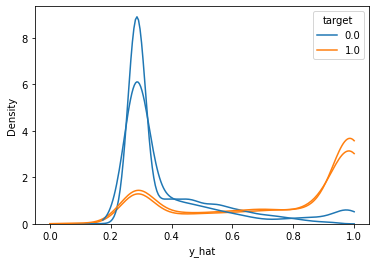

In [ ]:
sns.kdeplot(data=df_train_preds, x = "y_hat", hue = "target", 
            common_norm = False, bw_method = 0.2,
            clip = (0,1), weights = 'edgeweight')
sns.kdeplot(data=df_test_preds, x="y_hat", hue = "target", 
            common_norm = False, bw_method = 0.2,
            clip = (0,1), weights = 'edgeweight')
plt.show()

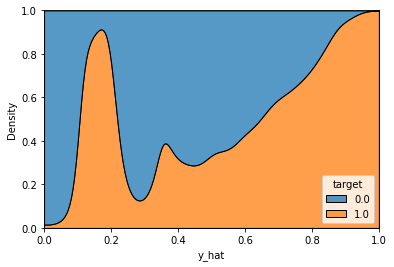

In [ ]:
cum_plot = sns.kdeplot(data = df_train_preds, x = "y_hat", hue = "target", 
                common_norm = False, bw_method = 0.2,
                clip = (0,1), weights = 'edgeweight', 
                multiple = "fill", legend = True)
cum_plot.legend_._set_loc(4)
plt.show()